In [1]:
import auction_data, os, analytics
hist_plot = auction_data.hist_plot
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cvxpy
sns.set_style('white')
%matplotlib inline

In [2]:
tsuchiura_data = auction_data.AuctionData('tests/reference_data/tsuchiura_data.csv')

In [3]:
deviations = [-.02, -.0001, .0, .0005]
demands = [tsuchiura_data.get_counterfactual_demand(rho) for rho in deviations]
print(demands)

[0.6938393464942137, 0.25238257317903334, 0.25017018379850237, 0.24727705922396187]


In [4]:
constraints = [analytics.MarkupConstraint(max_markup=.5),
               analytics.InformationConstraint(k=.5, sample_demands=demands)]

In [5]:
installed_solvers = cvxpy.installed_solvers()
print(installed_solvers)
solvers = ['ECOS']
print(solvers)

['ECOS', 'ECOS_BB', 'CVXOPT', 'GLPK', 'GLPK_MI', 'SCS', 'OSQP']
['ECOS']


seed=1, project=False, num_points=1000000.0, solver=ECOS


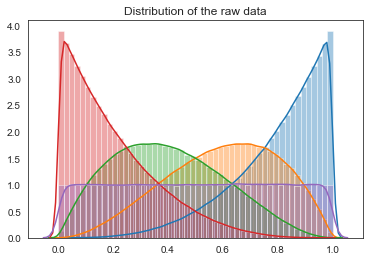

[[0.57886857 0.7888705 ]
 [0.16995513 0.35756573]
 [0.16830264 0.35486896]
 [0.1661465  0.35133236]]


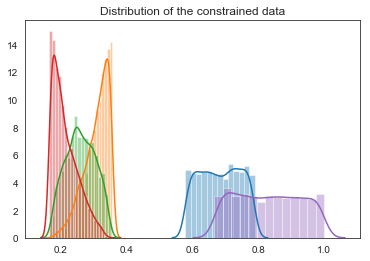


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +9.843e-01  -1.406e+00  +7e+02  9e-01  7e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.552e-01  -3.644e-01  +1e+02  3e-01  7e-02  1e-01  3e-01  0.8633  3e-02   1  1  1 |  0  0
 2  -7.060e-03  -2.148e-02  +1e+01  3e-02  5e-03  1e-02  3e-02  0.9356  2e-02   1  1  1 |  0  0
 3  +2.347e-03  -2.496e-03  +4e+00  1e-02  2e-03  3e-03  1e-02  0.6989  5e-02   1  1  1 |  0  0
 4  +8.646e-03  +3.803e-03  +4e+00  1e-02  2e-03  3e-03  9e-03  0.0648  8e-01   2  2  2 |  0  0
 5  +1.928e-02  +1.562e-02  +3e+00  7e-03  1e-03  2e-03  7e-03  0.3971  3e-01   2  2  2 |  0  0
 6  +9.730e-02  +9.393e-02  +2e+00  7e-03  4e-04  2e-03  6e-03  0.4172  6e-01   3  2  2 |  0  0
 7  +2.975e-01  +2.952e-01  +1e+00  7e-03  1e-04  2e-03  3e-03  0.5390  2e-01   2  2  3 |  0  0
 8  +2.683e-01  +2.660e-01  +1e+00  7e-03  1e-

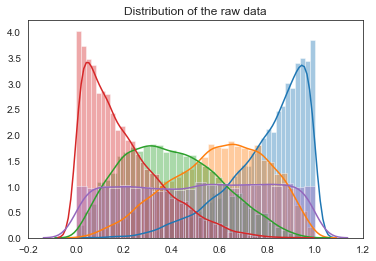

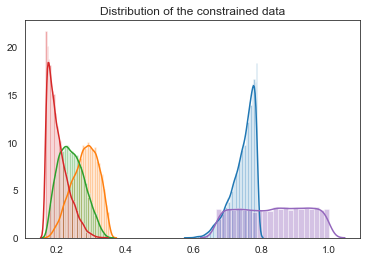

In [ ]:
for solver in solvers:
    if solver not in installed_solvers:
        continue
    for seed in [1]:
        for project in [False, True]:
            num_points = 1e6 * (1 - project) + 1e4 * project
            print(20*'=' + '\n'
                  + 'seed={}, project={}, num_points={}, solver={}'.format(seed, project, num_points, solver))

            try:
                min_collusion_solver = analytics.MinCollusionSolver(
                    data=tsuchiura_data,
                    deviations=deviations,
                    tolerance=2 * 1./tsuchiura_data.df_bids.shape[0],
                    metric=analytics.IsNonCompetitive,
                    plausibility_constraints=constraints,
                    num_points=num_points,
                    seed=seed,
                    project=project,
                    solver_type=solver
                    )

                env = min_collusion_solver.environment
                raw_data = env._generate_raw_environments(num_points, seed=seed)
                
                for data_id in range(0,raw_data.shape[1]):
                    sns.distplot(raw_data[:, data_id])
                plt.title('Distribution of the raw data')    
                plt.show()
                
                data = env._apply_constraints(raw_data)
                
                for data_id in range(0,data.shape[1]):
                    sns.distplot(data[:,data_id])
                plt.title('Distribution of the constrained data') 
                plt.show()
                                
                print('minimum share of collusive histories: {}'.format(min_collusion_solver.solution))
                print(min_collusion_solver.argmin.sort_values("prob", ascending=False).head(10))

            except Exception as e:
                print('Solver error: {}'.format(e))
                pass